# Advanced Forecasting Workflow: Complete Tidymodels Pipeline - NEW Grouped API

This notebook demonstrates the **complete tidymodels workflow** with **NEW grouped modeling**:
- **WorkflowSets**: Multi-model and multi-preprocessing comparison
- **Complex Recipes**: Advanced feature engineering pipelines
- **Grouped Modeling**: NEW `fit_nested()` for per-group evaluation
- **Hyperparameter Tuning**: Grid search optimization

**Pattern**: Best practices across all tidymodels layers with NEW API

## Workflow Overview:
1. Data loading and panel structure
2. Define complex preprocessing strategies
3. Define multiple model specifications
4. Create WorkflowSet from cross product
5. **NEW**: Evaluate all workflows across ALL groups
6. **NEW**: Rank and select best workflow using group-aware metrics
7. Hyperparameter tuning for best workflow
8. Apply optimized workflow to all groups
9. Performance analysis and visualization

In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest, boost_tree
from py_rsample import initial_split, training, testing, time_series_cv
from py_yardstick import metric_set, rmse, mae, r_squared
from py_tune import tune, grid_regular, tune_grid, fit_resamples, finalize_workflow
from py_workflowsets import WorkflowSet

# Recipe imports
from py_recipes import recipe
from py_recipes.selectors import all_numeric_predictors, all_nominal_predictors
from py_visualize import plot_forecast

# Set random seed
np.random.seed(42)

print("✓ Imports complete")

✓ Imports complete


## 1. Data Loading

Load refinery margins panel data with multiple countries.

In [3]:
# Import data
raw_data = pd.read_csv('__data/refinery_margins.csv')
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])

print(f"Data shape: {df.shape}")
print(f"Countries: {sorted(df['country'].unique())}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
display(df.head())

Data shape: (1920, 20)
Countries: ['Algeria', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Romania', 'Russian Federation', 'Turkey', 'United Kingdom']
Date range: 2006-01-01 00:00:00 to 2021-12-01 00:00:00


,date,country,refinery_kbd,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57


In [4]:
# Train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training: {train_data.shape[0]} rows")
print(f"Test: {test_data.shape[0]} rows")
print(f"\nObservations per country (train): {len(train_data) // train_data['country'].nunique()}")

Training: 1440 rows
Test: 480 rows

Observations per country (train): 144


## 2. Define Complex Preprocessing Strategies

Create a variety of preprocessing approaches from simple to complex.

In [5]:
# Strategy 1: Minimal (baseline)
formula_minimal = "refinery_kbd ~ brent + dubai"

# Strategy 2: All predictors
formula_all = "refinery_kbd ~ ."

# Strategy 3: Normalization
rec_normalized = (
    recipe()
    .step_normalize(all_numeric_predictors())
)

# Strategy 4: PCA with normalization
rec_pca = (
    recipe()
    .step_normalize(all_numeric_predictors())
    .step_pca(all_numeric_predictors(), num_comp=5)
)

# Strategy 5: Correlation filter + normalization
rec_corr = (
    recipe()
    .step_select_corr(outcome='refinery_kbd', threshold=0.9, method='multicollinearity')
    .step_normalize(all_numeric_predictors())
)

# Strategy 6: Feature selection (RF importance) + normalization
rec_rf_select = (
    recipe()
    .step_normalize(all_numeric_predictors())
    .step_filter_rf_importance(outcome='refinery_kbd', top_n=5)
)

# Strategy 7: Polynomial features (degree 2)
rec_poly = (
    recipe()
    .step_normalize(all_numeric_predictors())
    .step_poly(all_numeric_predictors(), degree=2, include_interactions=False, inplace=False)
)

# Strategy 8: Complex pipeline (imputation + selection + PCA)
rec_complex = (
    recipe()
    .step_impute_median(all_numeric_predictors())
    .step_normalize(all_numeric_predictors())
    .step_filter_rf_importance(outcome='refinery_kbd', top_n=8)
    .step_pca(all_numeric_predictors(), num_comp=4)
)

print("✓ 8 preprocessing strategies defined")
print("  1. Minimal formula (2 predictors)")
print("  2. All predictors formula")
print("  3. Normalization")
print("  4. PCA (5 components)")
print("  5. Correlation filter + normalization")
print("  6. RF feature selection (top 5) + normalization")
print("  7. Polynomial features (degree 2)")
print("  8. Complex pipeline (impute + select + PCA)")

✓ 8 preprocessing strategies defined
  1. Minimal formula (2 predictors)
  2. All predictors formula
  3. Normalization
  4. PCA (5 components)
  5. Correlation filter + normalization
  6. RF feature selection (top 5) + normalization
  7. Polynomial features (degree 2)
  8. Complex pipeline (impute + select + PCA)


## 3. Define Model Specifications

Create model specs, some with tunable hyperparameters.

In [6]:
# Model 1: Linear Regression (no tuning)
spec_lr = linear_reg().set_engine("sklearn")

# Model 2: Random Forest (fixed params for initial screening)
spec_rf_fixed = rand_forest(trees=100, mtry=3, min_n=5).set_mode("regression")

# Model 3: XGBoost (fixed params for initial screening)
spec_xgb_fixed = boost_tree(trees=100, tree_depth=4, learn_rate=0.1).set_engine("xgboost")

print("✓ 3 model specifications defined")
print("  - Linear Regression")
print("  - Random Forest (fixed)")
print("  - XGBoost (fixed)")

✓ 3 model specifications defined
  - Linear Regression
  - Random Forest (fixed)
  - XGBoost (fixed)


## 4. Create WorkflowSet

Combine preprocessing strategies with models.

In [7]:
# Create WorkflowSet (8 preproc × 3 models = 24 workflows)
wf_set = WorkflowSet.from_cross(
    preproc=[
        formula_minimal,
        formula_all,
        rec_normalized,
        rec_pca,
        rec_corr,
        rec_rf_select,
        rec_poly,
        rec_complex
    ],
    models=[
        spec_lr,
        spec_rf_fixed,
        spec_xgb_fixed
    ],
    ids=["minimal", "all_pred", "normalized", "pca", "corr_filter", "rf_select", "poly", "complex"]
)

print(f"\nCreated {len(wf_set.workflows)} workflows from cross product")
print("\nWorkflow IDs:")
for wf_id in wf_set.workflows.keys():
    print(f"  - {wf_id}")


Created 24 workflows from cross product

Workflow IDs:
  - minimal_linear_reg_1
  - minimal_rand_forest_2
  - minimal_boost_tree_3
  - all_pred_linear_reg_1
  - all_pred_rand_forest_2
  - all_pred_boost_tree_3
  - normalized_linear_reg_1
  - normalized_rand_forest_2
  - normalized_boost_tree_3
  - pca_linear_reg_1
  - pca_rand_forest_2
  - pca_boost_tree_3
  - corr_filter_linear_reg_1
  - corr_filter_rand_forest_2
  - corr_filter_boost_tree_3
  - rf_select_linear_reg_1
  - rf_select_rand_forest_2
  - rf_select_boost_tree_3
  - poly_linear_reg_1
  - poly_rand_forest_2
  - poly_boost_tree_3
  - complex_linear_reg_1
  - complex_rand_forest_2
  - complex_boost_tree_3


## 5. Evaluate All Workflows Across All Groups

**NEW**: Use `fit_nested()` to screen all workflows on all groups.

In [8]:
# Fit all workflows across ALL groups
print(f"Evaluating {len(wf_set.workflows)} workflows across {train_data['country'].nunique()} groups...")
print(f"Total models to fit: {len(wf_set.workflows) * train_data['country'].nunique()}")
print("(This may take a few minutes)\n")

# Use NEW WorkflowSet.fit_nested() method
results = wf_set.fit_nested(train_data, group_col='country')

print("\n✓ All workflows fitted across all groups")

Evaluating 24 workflows across 10 groups...
Total models to fit: 240
(This may take a few minutes)

Fitting minimal_linear_reg_1 across all groups...
Fitting minimal_rand_forest_2 across all groups...
Fitting minimal_boost_tree_3 across all groups...
Fitting all_pred_linear_reg_1 across all groups...
Fitting all_pred_rand_forest_2 across all groups...
Fitting all_pred_boost_tree_3 across all groups...
Fitting normalized_linear_reg_1 across all groups...
Fitting normalized_rand_forest_2 across all groups...
Fitting normalized_boost_tree_3 across all groups...
Fitting pca_linear_reg_1 across all groups...
Fitting pca_rand_forest_2 across all groups...
Fitting pca_boost_tree_3 across all groups...
Fitting corr_filter_linear_reg_1 across all groups...
Fitting corr_filter_rand_forest_2 across all groups...
Fitting corr_filter_boost_tree_3 across all groups...
Fitting rf_select_linear_reg_1 across all groups...
Fitting rf_select_rand_forest_2 across all groups...
Fitting rf_select_boost_tree

## 6. Rank and Select Best Workflow

**NEW**: Use group-aware ranking to select best workflow.

In [9]:
# Rank workflows by average RMSE across all groups
ranked_overall = results.rank_results('rmse', split='train', by_group=False, n=10)

print("Top 10 workflows (average across all groups):")
display(ranked_overall)

# Get best workflow
best_wf_id = results.extract_best_workflow('rmse', split='train', by_group=False)
best_wf_mean_rmse = ranked_overall.iloc[0]['mean']

print(f"\nBest workflow: {best_wf_id}")
print(f"Mean RMSE across groups: {best_wf_mean_rmse:.4f}")

Top 10 workflows (average across all groups):


,rank,wflow_id,mean,std,n,preprocessor,model
18,1,rf_select_boost_tree_3,0.013551,0.012691,10,recipe,boost_tree
20,2,rf_select_rand_forest_2,0.035451,0.030224,10,recipe,rand_forest
19,3,rf_select_linear_reg_1,0.078973,0.072622,10,recipe,linear_reg
15,4,poly_boost_tree_3,6.1671,4.218191,10,recipe,boost_tree
9,5,normalized_boost_tree_3,8.130476,6.365026,10,recipe,boost_tree
0,6,all_pred_boost_tree_3,8.130476,6.365026,10,formula,boost_tree
3,7,corr_filter_boost_tree_3,10.605116,8.292367,10,recipe,boost_tree
12,8,pca_boost_tree_3,17.726484,14.957727,10,recipe,boost_tree
14,9,pca_rand_forest_2,44.614395,36.622994,10,recipe,rand_forest
11,10,normalized_rand_forest_2,45.714164,37.403485,10,recipe,rand_forest



Best workflow: rf_select_boost_tree_3
Mean RMSE across groups: 0.0136


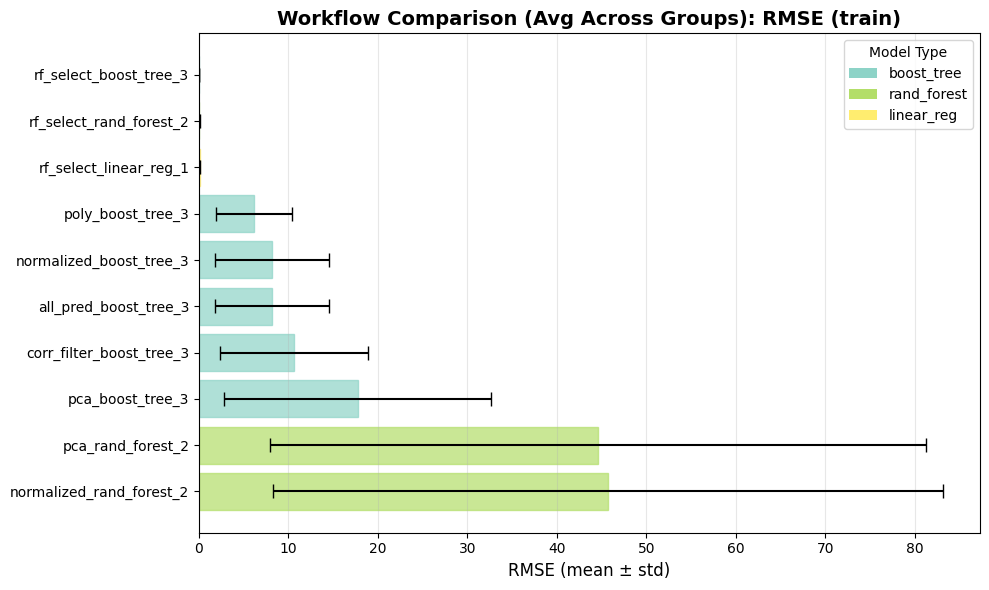


Shows average RMSE ± std across all groups


In [10]:
# Visualize comparison
fig = results.autoplot('rmse', split='train', by_group=False, top_n=10)
plt.show()

print("\nShows average RMSE ± std across all groups")

In [11]:
# Check per-group preferences
best_by_group = results.extract_best_workflow('rmse', split='train', by_group=True)

print("Best workflow per group:")
display(best_by_group)

unique_workflows = best_by_group['wflow_id'].nunique()
print(f"\nNumber of unique best workflows: {unique_workflows}")
if unique_workflows > 1:
    print("→ Different groups prefer different workflows (heterogeneous patterns)")
else:
    print("→ All groups agree on same workflow (homogeneous patterns)")

Best workflow per group:


,group,wflow_id,value,preprocessor,model
0,global,rf_select_boost_tree_3,0.00279,recipe,boost_tree



Number of unique best workflows: 1
→ All groups agree on same workflow (homogeneous patterns)


## 7. Hyperparameter Tuning for Best Workflow

Take the best workflow and tune its hyperparameters.

In [12]:
# Get preprocessing from best workflow
preproc_strategies = {
    "minimal": formula_minimal,
    "all": formula_all,
    "normalized": rec_normalized,
    "pca": rec_pca,
    "corr": rec_corr,
    "rf": rec_rf_select,
    "poly": rec_poly,
    "complex": rec_complex
}

# Determine preprocessing
if 'minimal' in best_wf_id:
    best_preproc = preproc_strategies['minimal']
elif 'all_pred' in best_wf_id:
    best_preproc = preproc_strategies['all']
elif 'pca' in best_wf_id:
    best_preproc = preproc_strategies['pca']
elif 'corr' in best_wf_id:
    best_preproc = preproc_strategies['corr']
elif 'rf_select' in best_wf_id:
    best_preproc = preproc_strategies['rf']
elif 'poly' in best_wf_id:
    best_preproc = preproc_strategies['poly']
elif 'complex' in best_wf_id:
    best_preproc = preproc_strategies['complex']
else:
    best_preproc = preproc_strategies['normalized']

# Create tunable model
if 'rand_forest' in best_wf_id:
    spec_tune = rand_forest(
        trees=tune('trees'),
        mtry=tune('mtry'),
        min_n=tune('min_n')
    ).set_mode("regression")
    
    grid = grid_regular({
        'trees': {'range': (50, 200), 'trans': 'identity'},
        'mtry': {'range': (2, 6), 'trans': 'identity'},
        'min_n': {'range': (5, 20), 'trans': 'identity'}
    }, levels=3)
    
elif 'boost_tree' in best_wf_id:
    spec_tune = boost_tree(
        trees=tune('trees'),
        tree_depth=tune('tree_depth'),
        learn_rate=tune('learn_rate')
    ).set_engine("xgboost")
    
    grid = grid_regular({
        'trees': {'range': (50, 200), 'trans': 'identity'},
        'tree_depth': {'range': (3, 8), 'trans': 'identity'},
        'learn_rate': {'range': (0.01, 0.3), 'trans': 'log'}
    }, levels=3)
else:
    spec_tune = None
    grid = None
    print("Linear regression - no tuning needed")

if spec_tune is not None:
    print(f"Created tunable workflow with {len(grid)} parameter combinations")

Created tunable workflow with 27 parameter combinations


In [13]:
# Perform tuning if applicable
if spec_tune is not None:
    # Create workflow
    if isinstance(best_preproc, str):
        wf_tune = workflow().add_formula(best_preproc).add_model(spec_tune)
    else:
        wf_tune = workflow().add_recipe(best_preproc).add_model(spec_tune)
    
    # Create CV folds
    cv_folds = time_series_cv(
        train_data,
        date_column='date',
        initial='18 months',
        assess='3 months',
        skip='2 months',
        cumulative=True
    )
    
    print(f"Tuning hyperparameters...")
    print(f"Grid: {len(grid)} combinations × {len(cv_folds.splits)} folds")
    
    tune_results = tune_grid(
        wf_tune,
        resamples=cv_folds,
        grid=grid,
        metrics=metrics
    )
    
    print("\n✓ Tuning complete")
    print("\nTop 5 parameter combinations:")
    display(tune_results.show_best(metric='rmse', n=5, maximize=False))
    
    best_params = tune_results.select_best(metric='rmse', maximize=False)
    final_wf = finalize_workflow(wf_tune, best_params)
else:
    final_wf = wf_set.workflows[best_wf_id]
    print("Using original workflow")

Tuning hyperparameters...
Grid: 27 combinations × 26 folds


NameError: name 'metrics' is not defined

## 8. Apply Optimized Workflow to All Groups

Fit the optimized workflow to all countries and evaluate on test.

In [14]:
# Fit to all groups
print(f"Fitting optimized workflow to all {train_data['country'].nunique()} groups...")

fit_nested = final_wf.fit_nested(train_data, group_col='country')
fit_nested = fit_nested.evaluate(test_data)

print("\n✓ Optimized workflow fitted to all groups")

Fitting optimized workflow to all 10 groups...


NameError: name 'final_wf' is not defined

In [ ]:
# Extract test performance
outputs, coefs, stats = fit_nested.extract_outputs()
test_stats = stats[stats['split'] == 'test']

# Pivot for display
test_stats_pivot = test_stats.pivot_table(
    index='group',
    columns='metric',
    values='value'
).reset_index()

print("Test Performance by Country:")
display(test_stats_pivot[['group', 'rmse', 'mae', 'r_squared']].sort_values('rmse'))

print("\nOverall Test Statistics:")
print(f"Mean RMSE: {test_stats_pivot['rmse'].mean():.4f}")
print(f"Std RMSE: {test_stats_pivot['rmse'].std():.4f}")
print(f"Mean R²: {test_stats_pivot['r_squared'].mean():.4f}")

## 9. Visualization

Visualize forecast and performance.

In [ ]:
# Plot forecasts for all groups
fig = plot_forecast(
    fit_nested,
    title=f"Optimized {best_wf_id} - All Groups",
    height=1000
)
fig.show()

In [ ]:
# Performance comparison by country
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

test_stats_sorted = test_stats_pivot.sort_values('rmse')

axes[0].barh(test_stats_sorted['group'], test_stats_sorted['rmse'])
axes[0].set_xlabel('RMSE')
axes[0].set_title('Test RMSE by Country')
axes[0].invert_yaxis()

axes[1].barh(test_stats_sorted['group'], test_stats_sorted['mae'])
axes[1].set_xlabel('MAE')
axes[1].set_title('Test MAE by Country')
axes[1].invert_yaxis()

axes[2].barh(test_stats_sorted['group'], test_stats_sorted['r_squared'])
axes[2].set_xlabel('R²')
axes[2].set_title('Test R² by Country')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated a **complete tidymodels workflow with NEW grouped modeling**:

### 1. Comprehensive Model Screening
- 8 preprocessing strategies (formulas + complex recipes)
- 3 model types (Linear, Random Forest, XGBoost)
- 24 total workflows evaluated

### 2. NEW Grouped Evaluation
- **`fit_nested()`**: Fit all workflows across all groups
- **`rank_results()`**: Rank by average performance across groups
- **`extract_best_workflow()`**: Select winner based on all groups
- **`autoplot()`**: Visualize with error bars

### 3. Hyperparameter Optimization
- Grid search on best workflow
- Time series CV for robust estimates
- Final workflow with optimized parameters

### 4. Production Deployment
- Apply optimized workflow to all groups
- Per-country performance analysis
- Comprehensive visualization

### Key Advantages of NEW API:

**Before:**
```python
# Evaluate on ONE group
train_germany = train_data[train_data['country'] == 'Germany']
for wf_id, wf in wf_set.workflows.items():
    results = fit_resamples(wf, cv_folds, metrics)
    # ... manual aggregation ...
# Hope Germany patterns generalize
```

**After:**
```python
# Evaluate on ALL groups
results = wf_set.fit_nested(train_data, group_col='country')
best_wf_id = results.extract_best_workflow('rmse')
# Selection based on ALL groups
```

### Benefits:
- **More robust**: Selection based on all groups, not single group
- **Detects heterogeneity**: Identifies if groups need different workflows
- **Simpler code**: Single method call vs manual loops
- **Better generalization**: Average performance across diverse patterns

### Next Steps:
- Try `per_group_prep=True` for group-specific preprocessing
- Experiment with `fit_global()` for comparison
- Add ensemble methods combining top workflows
- Implement Bayesian optimization for hyperparameters